# Scraping weather data from Environment Canada website

This notebook shows my exploratory process to develop code for downloading weather data (past 24 hours data for an airport weather station) and scraping the HTML to extract and parse the data into a `pandas` dataframe. 

I'm using the `requests` library read the web page, the Beautiful Soup library (`bs4`) to parse the HTML, the regular expressions library (`re`) to parse data from text, and the `pandas` library to organize the data into a dataframe.

After this exploratory process, I consolidated the code into a script `ecweather.py` that can be run from the Anaconda prompt (or other command line terminal) with `python ecweather.py output_file.csv`.

In [1]:
import bs4
import pandas as pd
import requests
import re

from ipywidgets import interact
from IPython.display import display

%matplotlib inline

## Read HTML file from web page

In [2]:
def open_url(url, headers=None):
    """Read url and return as BeautifulSoup object."""
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    soup = bs4.BeautifulSoup(res.text, 'lxml')
    return soup

In [3]:
station_code = 'yvr'
#station_code = 'yxe'
url = f'https://weather.gc.ca/past_conditions/index_e.html?station={station_code}'
soup = open_url(url)

# Display the first 1000 characters of the HTML document
soup.prettify()[:1000]

'<!DOCTYPE html>\n<!--[if lt IE 9]><html class="no-js lt-ie9" lang="en" dir="ltr"><![endif]-->\n<!--[if gt IE 8]><!-->\n<html class="no-js" dir="ltr" lang="en">\n <!--<![endif]-->\n <head>\n  <meta charset="utf-8"/>\n  <!-- Web Experience Toolkit (WET) / BoÃ®te Ã\xa0 outils de l\'expÃ©rience Web (BOEW)\r\n\t\twet-boew.github.io/wet-boew/License-en.html / wet-boew.github.io/wet-boew/Licence-fr.html -->\n  <meta content="width=device-width, initial-scale=1" name="viewport"/>\n  <meta content="Environment Canada" name="dcterms.creator"/>\n  <meta content="eng" name="dcterms.language" title="ISO639-2"/>\n  <meta content="Hourly weather conditions summary for the past 24 hours.  This includes conditions, temperature, humidity, dew point, wind speed/direction, air pressure, visibility, and wind chill/humidex (when applicable)" name="description"/>\n  <meta content="Weather; Meteorology; Climate; Weather Forecasts; Trends" name="dcterms.subject" title="scheme"/>\n  <meta content="2013-04-16" 

## Parse data from HTML

### Extract station information from the page title and body

In [4]:
def parse_station_name(soup):
    """Return the station name parsed from html document title"""
    remove = ' - Past 24 Hour Conditions - Environment Canada'
    station_name = soup.title.text.replace(remove, '').strip()
    
    # Hacky workaround to handle accented e in Montreal
    station_name = station_name.encode('ascii', 'replace').decode('utf-8')
    station_name = station_name.replace('??', 'e')
    
    return station_name

In [5]:
station_name = parse_station_name(soup)
station_name

"Vancouver Int'l Airport"

In [6]:
def parse_latlon(soup):
    """Return lat, lon parsed from html document"""
    coords = {}
    for nm in ['Latitude', 'Longitude']:
        regex = nm + ' [0-9]*.[0-9]'
        matches = re.findall(regex, soup.text)
        if len(matches) == 0:
            raise ValueError('Unable to find latitude')
        coords[nm] = float(matches[0].split(' ')[1].strip())
   
    # Longitude for all Canadian stations is deg W so convert to negative value
    coords['Longitude'] = -1 * coords['Longitude']
    return coords

In [7]:
coords = parse_latlon(soup)
coords

{'Latitude': 49.1, 'Longitude': -123.1}

### Find the table containing hourly weather data

In [8]:
items = soup.findAll('div', {'id' : 'table-container'})
table = items[0]
rows = table.find_all('tr')
nrows = len(rows)
print(f'Table with {nrows} rows')

Table with 28 rows


#### Use an interactive widget to explore each row of the table

This `interact` widget comes from the `ipywidgets` library, which is not included with the standard Anaconda distribution. To install `ipywidgets`, run the following command at the Anaconda prompt:
```
conda install -c conda-forge ipywidgets
```

In [9]:
# Explore table rows with interactive widget

@interact(row_number=(0, nrows - 1))
def show_row(row_number):
    row = rows[row_number]

    # First look for header row
    items = row.find_all('th')

    # If not a header row, look for body row
    if len(items) == 0:
        items = row.find_all('td')
    print(items)

interactive(children=(IntSlider(value=13, description='row_number', max=27), Output()), _dom_classes=('widget-interact',))

#### Types of rows in the table

From the above exploration, we can see that there are three types of rows in the data table:

- Main header: `<th class="wxo-tb-head vertical-center">`
- Date header: `<th class="wxo-th-bkg table-date">`
- Body row `<td class="text-center vertical-center">`

### Initial parsing of data from the table rows

In [10]:
def parse_row(row):
    """Return a list of items in the row, with some additional processing to clean the text data"""
    
    # First look for header rows
    entries = row.find_all('th')
    
     # Then look for table body rows
    if len(entries) == 0:
        entries = row.find_all('td')
        
    # List of items with extra whitespace stripped from exterior and interior of each string
    items = [re.sub(r'\s+', ' ', entry.text.strip()) for entry in entries]
    
    # Remove non-ascii characters from column names
    items = [item.encode('ascii', 'ignore').decode('utf-8') for item in items]
     
    return items

In [11]:
def parse_timezone_code(label):
    """Parse date/time label in table header for the 3-letter timezone code"""
    matches = re.findall('\(.*\)', label)
    if len(matches) == 0:
        raise ValueError(f'Cannot find timezone in {label}')
    timezone = matches[0].replace('(', '').replace(')', '')
    return timezone

In [12]:
def get_timezone(timezone_code):
    """Return timezone name for 3-letter timezone codes"""
    regions = ['Atlantic', 'Central', 'Eastern', 'Mountain', 'Newfoundland',
               'Pacific', 'Yukon']
    tz_dict = {}
    for region in regions:
        tz_dict[region[0] + 'ST'] = 'Canada/' + region
        tz_dict[region[0] + 'DT'] = 'Canada/' + region

    return tz_dict.get(timezone_code)

#### Wrangle data with lists

Create a nested list of the data in a preliminary form, where each item in the list is itself a list containing the items in a table row, with some some parsing and cleaning of the data

In [13]:
# Nested list of data

data_list = []
date_str = ''
header = ['Date'] + parse_row(rows[0])

# Deal with wonky labels for humidex columns
if 'Humidex' in header:
    ind = header.index('Humidex')
    header[ind] = 'Humidex (C)'
if 'Humidex' in header:
    ind2 = header.index('Humidex')
    header[ind2] = 'Humidex (F)'

timezone_code = parse_timezone_code(header[1])
timezone = get_timezone(timezone_code)
for row in rows[1:]:
    items = parse_row(row)
    if len(items) == 1:
        # Date header - incorporate as column in the data
        date_str = items[0]
    else:
        data_list.append([date_str] + items)

print(header)
data_list

['Date', 'Date / Time(PDT)', 'Conditions', 'Temperature (C)', 'Temperature (F)', 'Wind(km/h)', 'Wind(mph)', 'Humidex (C)', 'Humidex (F)', 'Relativehumidity(%)', 'Dew point(C)', 'Dew point(F)', 'Pressure(kPa)', 'Pressure(inches)', 'Visibility (km)', 'Visibility (mi)']


[['22 May 2018',
  '20:00',
  'Sunny',
  '18  (18.4)',
  '65  (65.1)',
  'W 5',
  'W 3',
  '*',
  '*',
  '70',
  '13',
  '55',
  '101.0',
  '29.8',
  '48',
  '30'],
 ['22 May 2018',
  '19:00',
  'Sunny',
  '20  (19.6)',
  '67  (67.3)',
  'WNW 9',
  'WNW 5',
  '*',
  '*',
  '67',
  '14',
  '56',
  '101.0',
  '29.8',
  '48',
  '30'],
 ['22 May 2018',
  '18:00',
  'Sunny',
  '20  (19.7)',
  '68  (67.5)',
  'WSW 11',
  'WSW 7',
  '*',
  '*',
  '59',
  '12',
  '53',
  '101.0',
  '29.8',
  '48',
  '30'],
 ['22 May 2018',
  '17:00',
  'Mainly Sunny',
  '20  (20.1) ',
  '68  (68.2) ',
  'WSW 9',
  'WSW 6',
  '23',
  '73',
  '64',
  '13',
  '56',
  '101.1',
  '29.9',
  '48',
  '30'],
 ['22 May 2018',
  '16:00',
  'Sunny',
  '19  (19.4)',
  '67  (66.9)',
  'WSW 10',
  'WSW 6',
  '*',
  '*',
  '67',
  '13',
  '56',
  '101.2',
  '29.9',
  '48',
  '30'],
 ['22 May 2018',
  '15:00',
  'Mainly Sunny',
  '20  (19.5)',
  '67  (67.1)',
  'WSW 12',
  'WSW 7',
  '*',
  '*',
  '62',
  '12',
  '54',
  '101.

In [14]:
print(f'Timezone: {timezone} ({timezone_code})')

Timezone: Canada/Pacific (PDT)


### Wrangle the data into a dataframe

Perform some parsing of the data and remove unnecessary columns

In [15]:
def parse_temperature(temp_str):
    """Return temperature value parsed from temperature string"""
    matches = re.findall('\(.*\)', temp_str)
    if len(matches) == 0:
        raise ValueError(f'Input {temp_str} does not match expected format')
    temp = float(matches[0].replace('(', '').replace(')', ''))
    return temp

In [16]:
def parse_wind(wind_str):
    """Return wind direction and wind speed parsed from wind string"""
    parts = wind_str.split(' ')
    if len(parts) == 1 and parts[0] == 'calm':
        wind_dir = None
        wind_speed = 0
    elif len(parts) >= 0:
        wind_dir = parts[0].strip()
        wind_speed = float(parts[1].strip())
    else:
        raise ValueError(f'Unable to parse wind {wind_str}')
    series = pd.Series([wind_dir, wind_speed], index=['Wind Direction', 'Wind Speed (km/hr)'])
    return series

In [17]:
def imperial_units(label):
    """Return True if the label identifies a variable in Imperial units"""
    imperial = False
    for nm in ['(F)', '(inches)', '(mph)', '(mi)']:
        if label.endswith(nm):
            imperial = True
            break
    return imperial

I initially developed the code below as a series of separate cells, corresponding to each stage of the data processing, so that I could look at the output at each step along the way. Once I'd finished this process, I consolidated all the cells into the single large cell below. I did this because modifying a variable (in this case the dataframe `data`) in different Jupyter notebook cells can be error prone due to the non-linear nature of the notebook environment. If I modify `data` and then jump back to a previous cell and execute the code, I could cause errors or modify the variable in unexpected ways that were not what I intended. For this reason, I always try to consolidate any modifications to a variable into a single cell after I've finished my initial exploratory process.

In [18]:
# Create dataframe
data = pd.DataFrame(data_list, columns=header)

print('\nInitial dataframe\n')
display(data.head(3))

# Remove columns with imperial measurements
cols_remove = [col for col in data.columns if imperial_units(col)]
data = data.drop(cols_remove, axis=1)

print('\nDropped extra columns\n')
display(data.head(3))

# Parse temperature strings
data['Temperature (C)'] = data['Temperature (C)'].apply(parse_temperature)

# Parse dates and set index to datetime
dt_format = '%d %b %Y %H:%M'
time_col = header[1]
times = pd.to_datetime(data['Date'] + ' ' + data[time_col], format=dt_format)
#times = pd.DatetimeIndex(times, tz=timezone)
data = data.set_index(times)
data.index.name = 'Datetime'
data = data.drop(['Date', time_col], axis=1)

# Parse wind data into separation columns for wind direction and speed
data = data.join(data['Wind(km/h)'].apply(parse_wind))
data = data.drop('Wind(km/h)', axis=1)

# Drop the extra hour at the end, so that the dataframe is 24 hours long
data = data[:24]

# Reverse the row order so that time is increasing down the table
data = data.iloc[::-1, :]
    
# Add station code, station name, lat, lon, timezone, and hour of day
columns = list(data.columns)
data['Station ID'] = station_code.upper()
data['Station Name'] = station_name
data['Latitude'] = coords['Latitude']
data['Longitude'] = coords['Longitude']
data['Timezone'] = timezone
data['Hour of Day'] = data.index.hour
columns = ['Station ID', 'Station Name', 'Latitude', 'Longitude', 'Timezone', 'Hour of Day'] + columns
data = data[columns]

print('\nFinal dataframe')
print(data.shape)
data


Initial dataframe



,Date,Date / Time(PDT),Conditions,Temperature (C),Temperature (F),Wind(km/h),Wind(mph),Humidex (C),Humidex (F),Relativehumidity(%),Dew point(C),Dew point(F),Pressure(kPa),Pressure(inches),Visibility (km),Visibility (mi)
0,22 May 2018,20:00,Sunny,18 (18.4),65 (65.1),W 5,W 3,*,*,70,13,55,101.0,29.8,48,30
1,22 May 2018,19:00,Sunny,20 (19.6),67 (67.3),WNW 9,WNW 5,*,*,67,14,56,101.0,29.8,48,30
2,22 May 2018,18:00,Sunny,20 (19.7),68 (67.5),WSW 11,WSW 7,*,*,59,12,53,101.0,29.8,48,30



Dropped extra columns



,Date,Date / Time(PDT),Conditions,Temperature (C),Wind(km/h),Humidex (C),Relativehumidity(%),Dew point(C),Pressure(kPa),Visibility (km)
0,22 May 2018,20:00,Sunny,18 (18.4),W 5,*,70,13,101.0,48
1,22 May 2018,19:00,Sunny,20 (19.6),WNW 9,*,67,14,101.0,48
2,22 May 2018,18:00,Sunny,20 (19.7),WSW 11,*,59,12,101.0,48



Final dataframe
(24, 15)


,Station ID,Station Name,Latitude,Longitude,Timezone,Hour of Day,Conditions,Temperature (C),Humidex (C),Relativehumidity(%),Dew point(C),Pressure(kPa),Visibility (km),Wind Direction,Wind Speed (km/hr)
Datetime,,,,,,,,,,,,,,,
2018-05-21 21:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,21,Mainly Clear,14.0,*,80,11,101.6,48,NaN,0.0
2018-05-21 22:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,22,Mainly Clear,14.8,*,75,10,101.6,48,N,5.0
2018-05-21 23:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,23,Clear,13.5,*,76,9,101.6,32,NaN,0.0
2018-05-22 00:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,0,Clear,13.1,*,77,9,101.6,32,E,11.0
2018-05-22 01:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,1,Clear,12.9,*,84,10,101.6,32,E,8.0
2018-05-22 02:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,2,Clear,12.2,*,88,10,101.6,32,E,12.0
2018-05-22 03:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,3,Clear,12.0,*,87,10,101.6,32,E,9.0
2018-05-22 04:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,4,Clear,11.9,*,88,10,101.6,32,N,2.0
2018-05-22 05:00:00,YVR,Vancouver Int'l Airport,49.1,-123.1,Canada/Pacific,5,Fog,10.4,*,97,10,101.6,48,N,2.0


## Explore the data a bit

In [19]:
data.describe()

,Latitude,Longitude,Hour of Day,Temperature (C),Wind Speed (km/hr)
count,24.0,2.400000e+01,24.000000,24.000000,24.000000
mean,49.1,-1.231000e+02,11.500000,15.520833,7.750000
std,0.0,4.354950e-14,7.071068,3.134517,4.636809
min,49.1,-1.231000e+02,0.000000,10.400000,0.000000
25%,49.1,-1.231000e+02,5.750000,12.975000,4.250000
50%,49.1,-1.231000e+02,11.500000,15.300000,9.000000
75%,49.1,-1.231000e+02,17.250000,18.500000,12.000000
max,49.1,-1.231000e+02,23.000000,20.100000,15.000000


In [20]:
data['Conditions'].value_counts()

Mainly Sunny     7
Clear            6
Partly Cloudy    4
Sunny            4
Mainly Clear     2
Fog              1
Name: Conditions, dtype: int64

In [21]:
data['Wind Direction'].value_counts()

WSW    7
E      4
N      4
SW     3
W      2
WNW    1
Name: Wind Direction, dtype: int64

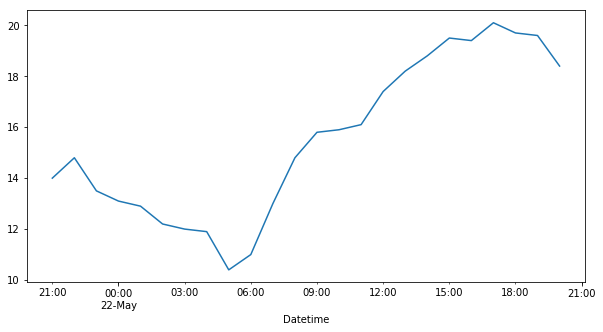

In [22]:
data['Temperature (C)'].plot.line(figsize=(10, 5))